## Data Prepare & Labeled

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

In [3]:
# df = pd.read_excel('dataset/redbook.xlsx')
# label_df = df.sample(1000)
# label_df.to_csv('dataset/sample_1000.csv')

In [4]:
sample_df = pd.read_excel('dataset/sample_1000.xlsx')
sample_df['category'] = sample_df['情感倾向'].apply(lambda x: 'O' if x == '其他' else x)

### EDA

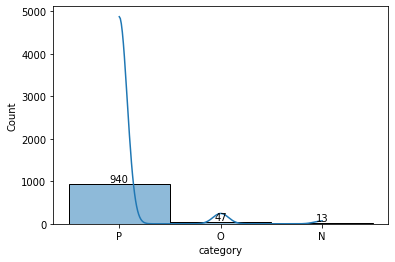

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

y = sns.histplot(sample_df['category'], kde=True, stat="count")
y.bar_label(y.containers[0])
plt.show()

### Text vectorization

In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('uer/roberta-base-finetuned-dianping-chinese')

Downloading:   0%|          | 0.00/295 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/107k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

### Model

In [7]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('uer/roberta-base-finetuned-dianping-chinese')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 3)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

### DataLoader

In [8]:
import torch
import numpy as np

labels = {'N': 0,
          'P': 1,
          'O': 2
          }


class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):

        self.labels = [labels[label] for label in df['category']]
        self.texts = [
            tokenizer(
                str(row["title"]) + " " + str(row["content"]),
                padding="max_length",
                max_length=512,
                truncation=True,
                return_tensors="pt",
            )
            for _, row in df.iterrows()
        ]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        try:
            return np.array(self.labels[idx])
        except:
            print(idx)
            print(self.labels)

    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y


### Training

In [9]:
import torch
import os
from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics import classification_report

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_target = torch.tensor(train.labels, dtype=torch.long)
    train_class_sample_count = torch.tensor([(train_target == t).sum() for t in torch.unique(train_target, sorted=True)])
    train_weight = 1. / train_class_sample_count.float()
    train_samples_weight = torch.tensor([train_weight[t] for t in train_target])

    train_dataloader = torch.utils.data.DataLoader(
        train, batch_size=2, 
        sampler=torch.utils.data.WeightedRandomSampler(train_samples_weight, len(train_samples_weight), replacement=True)
    )
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    # criterion = torch.hub.load(
    #     'adeelh/pytorch-multi-class-focal-loss',
    #     model='FocalLoss',
    #     alpha=train_weight,
    #     gamma=3,
    #     reduction='mean',
    #     force_reload=False
    # )
    criterion = nn.CrossEntropyLoss(weight=train_weight)

    start_epoch = 0
    optimizer = Adam(model.parameters(), lr=learning_rate)
    # if os.path.exists(continue_train_path):
    #     checkpoint = torch.load(continue_train_path)
    #     model.load_state_dict(checkpoint['model'])
    #     optimizer.load_state_dict(checkpoint['optimizer'])
    #     start_epoch = checkpoint['epoch']

    if use_cuda:

        model = model.cuda()
        criterion = criterion.cuda()

    best_model = None
    best_optimizer = None
    best_epoch = None
    best_val_loss = float('inf')
    best_true = None
    best_pred = None


    for epoch in range(start_epoch+1, epochs+1):

        total_acc_train = 0
        total_loss_train = 0
        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input["attention_mask"].to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)

            output = model(input_id, mask)

            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()

            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        total_acc_val = 0
        total_loss_val = 0

        val_pred = []
        with torch.no_grad():

            for val_input, val_label in val_dataloader:

                val_label = val_label.to(device)
                mask = val_input["attention_mask"].to(device)
                input_id = val_input["input_ids"].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()

                batch_val_pred = output.argmax(dim=1)
                val_pred = val_pred + batch_val_pred.tolist()
                acc = (batch_val_pred == val_label).sum().item()
                total_acc_val += acc

        var_acc = total_acc_val / len(val_data)
        var_loss = total_loss_val / len(val_data)
        print(
            f"Epochs: {epoch + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {var_loss: .3f} \
                | Val Accuracy: {var_acc: .3f}"
        )

        if best_val_loss > var_loss:
            best_val_loss = var_loss
            best_model = model
            best_optimizer = optimizer
            best_epoch = epoch
            best_true = val.labels
            best_pred = val_pred
        
    return best_model, best_optimizer, best_epoch, best_val_loss, best_true, best_pred


### Evaluate

In [10]:
import torch

def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    test_pred = []
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            batch_test_pred = output.argmax(dim=1)
            test_pred = test_pred + batch_test_pred.tolist()
            acc = (batch_test_pred == test_label).sum().item()
            total_acc_test += acc

    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return test_pred, test.labels


### Split data

In [61]:
import numpy as np

df_train, df_val, df_test = np.split(
    sample_df.sample(frac=1, random_state=42),
    [int(0.8 * len(sample_df)), int(0.9 * len(sample_df))],
)

In [12]:
import collections
history = collections.defaultdict(list)

EPOCHS = 20
LR = 1e-6

np.random.seed(112)

########## TODO: random labeled############
# sample_df['category'] = np.random.randint(0,4, size=len(sample_df))

# print(len(df_train), len(df_val), len(df_test))

un_P_df = sample_df[sample_df['category']!='P']

from sklearn.model_selection import KFold, StratifiedShuffleSplit, StratifiedKFold
kfold = KFold(n_splits=10,shuffle=True,random_state=42)

best_model = None
best_optimizer = None
best_epoch = None
best_val_loss = float('inf')
best_true = None
best_pred = None
for fold,(train_idx,test_idx) in enumerate(kfold.split(sample_df)):
    print('------------fold no---------{}----------------------'.format(fold))

    model = BertClassifier()
    
    train_df = pd.concat([sample_df.iloc[train_idx], un_P_df])
    val_df = pd.concat([sample_df.iloc[test_idx], un_P_df])
    best_model_, best_optimizer_, best_epoch_, best_val_loss_, best_true_, best_pred_ = train(model, train_df.reset_index(drop=True), val_df.reset_index(drop=True), LR, EPOCHS)
    if best_val_loss > best_val_loss_:
        best_val_loss = best_val_loss_
        best_model = best_model_
        best_optimizer = best_optimizer_
        best_epoch = best_epoch_
        best_true = best_true_
        best_pred = best_pred_
        # save model
        torch.save({
            'model': best_model.state_dict(),
            'optimizer': best_optimizer.state_dict(),
            'epoch': best_epoch,
            'fold': fold,
        }, f'./model/bert_best_model.pth')
    print(f"fold: {fold}: \n{classification_report(best_true, best_pred)}")
    history['pred'].append(best_pred)
    history['true'].append(best_true)
torch.save({'history': history}, f'./model/history.pth')

------------fold no---------0----------------------


Downloading:   0%|          | 0.00/390M [00:00<?, ?B/s]

Some weights of the model checkpoint at uer/roberta-base-finetuned-dianping-chinese were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 480/480 [00:57<00:00,  8.30it/s]


Epochs: 2 | Train Loss:  0.518                 | Train Accuracy:  0.372                 | Val Loss:  0.591                 | Val Accuracy:  0.163


100%|██████████| 480/480 [00:58<00:00,  8.17it/s]


Epochs: 3 | Train Loss:  0.420                 | Train Accuracy:  0.477                 | Val Loss:  0.534                 | Val Accuracy:  0.412


100%|██████████| 480/480 [00:59<00:00,  8.13it/s]


Epochs: 4 | Train Loss:  0.275                 | Train Accuracy:  0.744                 | Val Loss:  0.395                 | Val Accuracy:  0.675


100%|██████████| 480/480 [00:58<00:00,  8.16it/s]


Epochs: 5 | Train Loss:  0.177                 | Train Accuracy:  0.833                 | Val Loss:  0.276                 | Val Accuracy:  0.750


100%|██████████| 480/480 [00:58<00:00,  8.15it/s]


Epochs: 6 | Train Loss:  0.122                 | Train Accuracy:  0.877                 | Val Loss:  0.177                 | Val Accuracy:  0.856


100%|██████████| 480/480 [00:58<00:00,  8.14it/s]


Epochs: 7 | Train Loss:  0.086                 | Train Accuracy:  0.919                 | Val Loss:  0.127                 | Val Accuracy:  0.912


100%|██████████| 480/480 [00:59<00:00,  8.11it/s]


Epochs: 8 | Train Loss:  0.066                 | Train Accuracy:  0.947                 | Val Loss:  0.086                 | Val Accuracy:  0.975


100%|██████████| 480/480 [00:59<00:00,  8.12it/s]


Epochs: 9 | Train Loss:  0.055                 | Train Accuracy:  0.957                 | Val Loss:  0.079                 | Val Accuracy:  0.969


100%|██████████| 480/480 [00:59<00:00,  8.04it/s]


Epochs: 10 | Train Loss:  0.033                 | Train Accuracy:  0.978                 | Val Loss:  0.058                 | Val Accuracy:  0.975


100%|██████████| 480/480 [00:59<00:00,  8.07it/s]


Epochs: 11 | Train Loss:  0.024                 | Train Accuracy:  0.984                 | Val Loss:  0.047                 | Val Accuracy:  0.981


100%|██████████| 480/480 [00:59<00:00,  8.07it/s]


Epochs: 12 | Train Loss:  0.016                 | Train Accuracy:  0.986                 | Val Loss:  0.042                 | Val Accuracy:  0.981


100%|██████████| 480/480 [00:59<00:00,  8.08it/s]


Epochs: 13 | Train Loss:  0.014                 | Train Accuracy:  0.989                 | Val Loss:  0.034                 | Val Accuracy:  0.988


100%|██████████| 480/480 [00:59<00:00,  8.10it/s]


Epochs: 14 | Train Loss:  0.009                 | Train Accuracy:  0.994                 | Val Loss:  0.028                 | Val Accuracy:  0.988


100%|██████████| 480/480 [00:59<00:00,  8.10it/s]


Epochs: 15 | Train Loss:  0.010                 | Train Accuracy:  0.996                 | Val Loss:  0.021                 | Val Accuracy:  0.988


100%|██████████| 480/480 [00:59<00:00,  8.07it/s]


Epochs: 16 | Train Loss:  0.008                 | Train Accuracy:  0.991                 | Val Loss:  0.022                 | Val Accuracy:  0.988


100%|██████████| 480/480 [00:59<00:00,  8.05it/s]


Epochs: 17 | Train Loss:  0.009                 | Train Accuracy:  0.992                 | Val Loss:  0.018                 | Val Accuracy:  0.988


100%|██████████| 480/480 [00:59<00:00,  8.09it/s]


Epochs: 18 | Train Loss:  0.005                 | Train Accuracy:  0.997                 | Val Loss:  0.016                 | Val Accuracy:  0.988


100%|██████████| 480/480 [00:59<00:00,  8.07it/s]


Epochs: 19 | Train Loss:  0.008                 | Train Accuracy:  0.996                 | Val Loss:  0.014                 | Val Accuracy:  0.988


100%|██████████| 480/480 [00:59<00:00,  8.09it/s]


Epochs: 20 | Train Loss:  0.003                 | Train Accuracy:  0.994                 | Val Loss:  0.012                 | Val Accuracy:  0.988


100%|██████████| 480/480 [00:59<00:00,  8.09it/s]


Epochs: 21 | Train Loss:  0.006                 | Train Accuracy:  0.993                 | Val Loss:  0.012                 | Val Accuracy:  0.988
fold: 0: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      0.98      0.99        97
           2       0.96      1.00      0.98        49

    accuracy                           0.99       160
   macro avg       0.99      0.99      0.99       160
weighted avg       0.99      0.99      0.99       160

------------fold no---------1----------------------


Some weights of the model checkpoint at uer/roberta-base-finetuned-dianping-chinese were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 480/480 [00:59<00:00,  8.09it/s]


Epochs: 2 | Train Loss:  0.513                 | Train Accuracy:  0.425                 | Val Loss:  0.540                 | Val Accuracy:  0.388


100%|██████████| 480/480 [00:59<00:00,  8.09it/s]


Epochs: 3 | Train Loss:  0.325                 | Train Accuracy:  0.633                 | Val Loss:  0.441                 | Val Accuracy:  0.569


100%|██████████| 480/480 [00:59<00:00,  8.11it/s]


Epochs: 4 | Train Loss:  0.176                 | Train Accuracy:  0.828                 | Val Loss:  0.346                 | Val Accuracy:  0.738


100%|██████████| 480/480 [00:59<00:00,  8.11it/s]


Epochs: 5 | Train Loss:  0.107                 | Train Accuracy:  0.911                 | Val Loss:  0.242                 | Val Accuracy:  0.838


100%|██████████| 480/480 [00:59<00:00,  8.09it/s]


Epochs: 6 | Train Loss:  0.092                 | Train Accuracy:  0.916                 | Val Loss:  0.176                 | Val Accuracy:  0.881


100%|██████████| 480/480 [00:59<00:00,  8.09it/s]


Epochs: 7 | Train Loss:  0.053                 | Train Accuracy:  0.943                 | Val Loss:  0.131                 | Val Accuracy:  0.900


100%|██████████| 480/480 [00:59<00:00,  8.10it/s]


Epochs: 8 | Train Loss:  0.033                 | Train Accuracy:  0.966                 | Val Loss:  0.116                 | Val Accuracy:  0.900


100%|██████████| 480/480 [00:59<00:00,  8.09it/s]


Epochs: 9 | Train Loss:  0.031                 | Train Accuracy:  0.964                 | Val Loss:  0.104                 | Val Accuracy:  0.906


100%|██████████| 480/480 [00:59<00:00,  8.06it/s]


Epochs: 10 | Train Loss:  0.018                 | Train Accuracy:  0.973                 | Val Loss:  0.096                 | Val Accuracy:  0.906


100%|██████████| 480/480 [00:59<00:00,  8.03it/s]


Epochs: 11 | Train Loss:  0.026                 | Train Accuracy:  0.966                 | Val Loss:  0.060                 | Val Accuracy:  0.950


100%|██████████| 480/480 [00:59<00:00,  8.10it/s]


Epochs: 12 | Train Loss:  0.017                 | Train Accuracy:  0.978                 | Val Loss:  0.058                 | Val Accuracy:  0.938


100%|██████████| 480/480 [00:59<00:00,  8.11it/s]


Epochs: 13 | Train Loss:  0.015                 | Train Accuracy:  0.981                 | Val Loss:  0.057                 | Val Accuracy:  0.938


100%|██████████| 480/480 [00:59<00:00,  8.10it/s]


Epochs: 14 | Train Loss:  0.013                 | Train Accuracy:  0.977                 | Val Loss:  0.049                 | Val Accuracy:  0.963


100%|██████████| 480/480 [00:59<00:00,  8.09it/s]


Epochs: 15 | Train Loss:  0.016                 | Train Accuracy:  0.975                 | Val Loss:  0.049                 | Val Accuracy:  0.950


100%|██████████| 480/480 [00:59<00:00,  8.08it/s]


Epochs: 16 | Train Loss:  0.010                 | Train Accuracy:  0.984                 | Val Loss:  0.047                 | Val Accuracy:  0.950


100%|██████████| 480/480 [00:59<00:00,  8.02it/s]


Epochs: 17 | Train Loss:  0.014                 | Train Accuracy:  0.989                 | Val Loss:  0.048                 | Val Accuracy:  0.944


100%|██████████| 480/480 [00:59<00:00,  8.07it/s]


Epochs: 18 | Train Loss:  0.010                 | Train Accuracy:  0.994                 | Val Loss:  0.045                 | Val Accuracy:  0.950


100%|██████████| 480/480 [00:59<00:00,  8.10it/s]


Epochs: 19 | Train Loss:  0.009                 | Train Accuracy:  0.988                 | Val Loss:  0.046                 | Val Accuracy:  0.944


100%|██████████| 480/480 [00:59<00:00,  8.09it/s]


Epochs: 20 | Train Loss:  0.005                 | Train Accuracy:  0.998                 | Val Loss:  0.041                 | Val Accuracy:  0.956


100%|██████████| 480/480 [00:59<00:00,  8.09it/s]


Epochs: 21 | Train Loss:  0.006                 | Train Accuracy:  0.996                 | Val Loss:  0.041                 | Val Accuracy:  0.969
fold: 1: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      0.98      0.99        97
           2       0.96      1.00      0.98        49

    accuracy                           0.99       160
   macro avg       0.99      0.99      0.99       160
weighted avg       0.99      0.99      0.99       160

------------fold no---------2----------------------


Some weights of the model checkpoint at uer/roberta-base-finetuned-dianping-chinese were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 480/480 [00:59<00:00,  8.05it/s]


Epochs: 18 | Train Loss:  0.007                 | Train Accuracy:  0.992                 | Val Loss:  0.023                 | Val Accuracy:  0.994


100%|██████████| 480/480 [00:59<00:00,  8.05it/s]


Epochs: 19 | Train Loss:  0.003                 | Train Accuracy:  0.994                 | Val Loss:  0.024                 | Val Accuracy:  0.994


100%|██████████| 480/480 [00:59<00:00,  8.06it/s]


Epochs: 20 | Train Loss:  0.003                 | Train Accuracy:  0.995                 | Val Loss:  0.023                 | Val Accuracy:  0.994


100%|██████████| 480/480 [00:59<00:00,  8.05it/s]


Epochs: 21 | Train Loss:  0.002                 | Train Accuracy:  0.998                 | Val Loss:  0.022                 | Val Accuracy:  0.994
fold: 2: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.99      1.00      0.99        92
           2       1.00      0.98      0.99        53

    accuracy                           0.99       160
   macro avg       1.00      0.99      1.00       160
weighted avg       0.99      0.99      0.99       160

------------fold no---------3----------------------


Some weights of the model checkpoint at uer/roberta-base-finetuned-dianping-chinese were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 480/480 [00:59<00:00,  8.03it/s]


Epochs: 2 | Train Loss:  0.527                 | Train Accuracy:  0.442                 | Val Loss:  0.539                 | Val Accuracy:  0.375


100%|██████████| 480/480 [00:59<00:00,  8.06it/s]


Epochs: 3 | Train Loss:  0.361                 | Train Accuracy:  0.657                 | Val Loss:  0.522                 | Val Accuracy:  0.412


100%|██████████| 480/480 [00:59<00:00,  8.06it/s]


Epochs: 4 | Train Loss:  0.213                 | Train Accuracy:  0.699                 | Val Loss:  0.481                 | Val Accuracy:  0.412


100%|██████████| 480/480 [00:59<00:00,  8.05it/s]


Epochs: 5 | Train Loss:  0.147                 | Train Accuracy:  0.731                 | Val Loss:  0.370                 | Val Accuracy:  0.631


100%|██████████| 480/480 [00:59<00:00,  8.05it/s]


Epochs: 6 | Train Loss:  0.095                 | Train Accuracy:  0.866                 | Val Loss:  0.223                 | Val Accuracy:  0.869


100%|██████████| 480/480 [00:59<00:00,  8.06it/s]


Epochs: 7 | Train Loss:  0.052                 | Train Accuracy:  0.946                 | Val Loss:  0.124                 | Val Accuracy:  0.944


100%|██████████| 480/480 [00:59<00:00,  8.05it/s]


Epochs: 8 | Train Loss:  0.036                 | Train Accuracy:  0.971                 | Val Loss:  0.082                 | Val Accuracy:  0.969


100%|██████████| 480/480 [00:59<00:00,  8.06it/s]


Epochs: 9 | Train Loss:  0.027                 | Train Accuracy:  0.975                 | Val Loss:  0.050                 | Val Accuracy:  0.981


100%|██████████| 480/480 [00:59<00:00,  8.00it/s]


Epochs: 10 | Train Loss:  0.020                 | Train Accuracy:  0.991                 | Val Loss:  0.038                 | Val Accuracy:  0.988


100%|██████████| 480/480 [00:59<00:00,  8.02it/s]


Epochs: 11 | Train Loss:  0.018                 | Train Accuracy:  0.983                 | Val Loss:  0.023                 | Val Accuracy:  1.000


100%|██████████| 480/480 [00:59<00:00,  8.05it/s]


Epochs: 12 | Train Loss:  0.011                 | Train Accuracy:  0.990                 | Val Loss:  0.020                 | Val Accuracy:  1.000


100%|██████████| 480/480 [00:59<00:00,  8.05it/s]


Epochs: 13 | Train Loss:  0.009                 | Train Accuracy:  0.991                 | Val Loss:  0.014                 | Val Accuracy:  1.000


100%|██████████| 480/480 [00:59<00:00,  8.06it/s]


Epochs: 14 | Train Loss:  0.006                 | Train Accuracy:  0.998                 | Val Loss:  0.010                 | Val Accuracy:  1.000


100%|██████████| 480/480 [00:59<00:00,  8.05it/s]


Epochs: 15 | Train Loss:  0.004                 | Train Accuracy:  0.997                 | Val Loss:  0.009                 | Val Accuracy:  1.000


100%|██████████| 480/480 [00:59<00:00,  8.05it/s]


Epochs: 16 | Train Loss:  0.004                 | Train Accuracy:  0.996                 | Val Loss:  0.007                 | Val Accuracy:  1.000


100%|██████████| 480/480 [00:59<00:00,  8.07it/s]


Epochs: 17 | Train Loss:  0.004                 | Train Accuracy:  0.996                 | Val Loss:  0.007                 | Val Accuracy:  1.000


100%|██████████| 480/480 [00:59<00:00,  8.03it/s]


Epochs: 18 | Train Loss:  0.003                 | Train Accuracy:  0.997                 | Val Loss:  0.005                 | Val Accuracy:  1.000


100%|██████████| 480/480 [00:59<00:00,  8.01it/s]


Epochs: 19 | Train Loss:  0.002                 | Train Accuracy:  0.995                 | Val Loss:  0.004                 | Val Accuracy:  1.000


100%|██████████| 480/480 [00:59<00:00,  8.03it/s]


Epochs: 20 | Train Loss:  0.003                 | Train Accuracy:  0.993                 | Val Loss:  0.003                 | Val Accuracy:  1.000


100%|██████████| 480/480 [00:59<00:00,  8.06it/s]


Epochs: 21 | Train Loss:  0.002                 | Train Accuracy:  0.996                 | Val Loss:  0.003                 | Val Accuracy:  1.000
fold: 3: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        95
           2       1.00      1.00      1.00        52

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160

------------fold no---------4----------------------


Some weights of the model checkpoint at uer/roberta-base-finetuned-dianping-chinese were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 480/480 [00:59<00:00,  8.12it/s]


Epochs: 2 | Train Loss:  0.542                 | Train Accuracy:  0.335                 | Val Loss:  0.544                 | Val Accuracy:  0.206


100%|██████████| 480/480 [00:59<00:00,  8.10it/s]


Epochs: 3 | Train Loss:  0.489                 | Train Accuracy:  0.487                 | Val Loss:  0.513                 | Val Accuracy:  0.375


100%|██████████| 480/480 [00:59<00:00,  8.07it/s]


Epochs: 4 | Train Loss:  0.304                 | Train Accuracy:  0.611                 | Val Loss:  0.443                 | Val Accuracy:  0.419


100%|██████████| 480/480 [00:59<00:00,  8.08it/s]


Epochs: 5 | Train Loss:  0.200                 | Train Accuracy:  0.658                 | Val Loss:  0.414                 | Val Accuracy:  0.412


100%|██████████| 480/480 [00:59<00:00,  8.04it/s]


Epochs: 6 | Train Loss:  0.199                 | Train Accuracy:  0.644                 | Val Loss:  0.395                 | Val Accuracy:  0.431


100%|██████████| 480/480 [00:59<00:00,  8.04it/s]


Epochs: 7 | Train Loss:  0.181                 | Train Accuracy:  0.669                 | Val Loss:  0.380                 | Val Accuracy:  0.463


100%|██████████| 480/480 [00:59<00:00,  8.03it/s]


Epochs: 8 | Train Loss:  0.162                 | Train Accuracy:  0.709                 | Val Loss:  0.371                 | Val Accuracy:  0.519


100%|██████████| 480/480 [00:59<00:00,  8.08it/s]


Epochs: 9 | Train Loss:  0.140                 | Train Accuracy:  0.747                 | Val Loss:  0.349                 | Val Accuracy:  0.662


100%|██████████| 480/480 [00:59<00:00,  8.04it/s]


Epochs: 10 | Train Loss:  0.131                 | Train Accuracy:  0.872                 | Val Loss:  0.264                 | Val Accuracy:  0.881


100%|██████████| 480/480 [00:59<00:00,  8.06it/s]


Epochs: 11 | Train Loss:  0.097                 | Train Accuracy:  0.916                 | Val Loss:  0.186                 | Val Accuracy:  0.887


100%|██████████| 480/480 [00:59<00:00,  8.04it/s]


Epochs: 12 | Train Loss:  0.046                 | Train Accuracy:  0.957                 | Val Loss:  0.101                 | Val Accuracy:  0.931


100%|██████████| 480/480 [00:59<00:00,  8.03it/s]


Epochs: 13 | Train Loss:  0.021                 | Train Accuracy:  0.966                 | Val Loss:  0.081                 | Val Accuracy:  0.938


100%|██████████| 480/480 [01:00<00:00,  7.99it/s]


Epochs: 14 | Train Loss:  0.018                 | Train Accuracy:  0.968                 | Val Loss:  0.072                 | Val Accuracy:  0.956


100%|██████████| 480/480 [00:59<00:00,  8.04it/s]


Epochs: 15 | Train Loss:  0.012                 | Train Accuracy:  0.977                 | Val Loss:  0.066                 | Val Accuracy:  0.963


100%|██████████| 480/480 [01:00<00:00,  8.00it/s]


Epochs: 16 | Train Loss:  0.010                 | Train Accuracy:  0.989                 | Val Loss:  0.056                 | Val Accuracy:  0.969


100%|██████████| 480/480 [00:59<00:00,  8.03it/s]


Epochs: 17 | Train Loss:  0.012                 | Train Accuracy:  0.982                 | Val Loss:  0.048                 | Val Accuracy:  0.988


100%|██████████| 480/480 [00:59<00:00,  8.04it/s]


Epochs: 18 | Train Loss:  0.008                 | Train Accuracy:  0.993                 | Val Loss:  0.045                 | Val Accuracy:  0.988


100%|██████████| 480/480 [00:59<00:00,  8.03it/s]


Epochs: 19 | Train Loss:  0.013                 | Train Accuracy:  0.994                 | Val Loss:  0.035                 | Val Accuracy:  0.988


100%|██████████| 480/480 [00:59<00:00,  8.02it/s]


Epochs: 20 | Train Loss:  0.007                 | Train Accuracy:  0.997                 | Val Loss:  0.029                 | Val Accuracy:  0.988


100%|██████████| 480/480 [00:59<00:00,  8.03it/s]


Epochs: 21 | Train Loss:  0.004                 | Train Accuracy:  0.999                 | Val Loss:  0.031                 | Val Accuracy:  0.988
fold: 4: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        95
           2       1.00      1.00      1.00        52

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160

------------fold no---------5----------------------


Some weights of the model checkpoint at uer/roberta-base-finetuned-dianping-chinese were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 480/480 [00:59<00:00,  8.03it/s]


Epochs: 4 | Train Loss:  0.149                 | Train Accuracy:  0.875                 | Val Loss:  0.219                 | Val Accuracy:  0.850


100%|██████████| 480/480 [00:59<00:00,  8.00it/s]


Epochs: 5 | Train Loss:  0.111                 | Train Accuracy:  0.898                 | Val Loss:  0.178                 | Val Accuracy:  0.875


100%|██████████| 480/480 [00:59<00:00,  8.03it/s]


Epochs: 6 | Train Loss:  0.088                 | Train Accuracy:  0.920                 | Val Loss:  0.144                 | Val Accuracy:  0.900


100%|██████████| 480/480 [00:59<00:00,  8.04it/s]


Epochs: 7 | Train Loss:  0.067                 | Train Accuracy:  0.935                 | Val Loss:  0.136                 | Val Accuracy:  0.906


100%|██████████| 480/480 [00:59<00:00,  8.04it/s]


Epochs: 8 | Train Loss:  0.056                 | Train Accuracy:  0.945                 | Val Loss:  0.115                 | Val Accuracy:  0.919


100%|██████████| 480/480 [00:59<00:00,  8.04it/s]


Epochs: 9 | Train Loss:  0.032                 | Train Accuracy:  0.963                 | Val Loss:  0.095                 | Val Accuracy:  0.944


 43%|████▎     | 206/480 [00:25<00:34,  7.95it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 480/480 [00:59<00:00,  8.02it/s]


Epochs: 18 | Train Loss:  0.006                 | Train Accuracy:  0.994                 | Val Loss:  0.031                 | Val Accuracy:  0.988


100%|██████████| 480/480 [01:00<00:00,  8.00it/s]


Epochs: 19 | Train Loss:  0.006                 | Train Accuracy:  0.996                 | Val Loss:  0.029                 | Val Accuracy:  0.988


100%|██████████| 480/480 [00:59<00:00,  8.01it/s]


Epochs: 20 | Train Loss:  0.006                 | Train Accuracy:  0.999                 | Val Loss:  0.031                 | Val Accuracy:  0.981


100%|██████████| 480/480 [01:00<00:00,  8.00it/s]


Epochs: 21 | Train Loss:  0.002                 | Train Accuracy:  1.000                 | Val Loss:  0.029                 | Val Accuracy:  0.988
fold: 5: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        95
           2       1.00      1.00      1.00        52

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160

------------fold no---------6----------------------


Some weights of the model checkpoint at uer/roberta-base-finetuned-dianping-chinese were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 480/480 [00:59<00:00,  8.05it/s]


Epochs: 2 | Train Loss:  0.500                 | Train Accuracy:  0.480                 | Val Loss:  0.514                 | Val Accuracy:  0.400


100%|██████████| 480/480 [00:59<00:00,  8.03it/s]


Epochs: 3 | Train Loss:  0.347                 | Train Accuracy:  0.660                 | Val Loss:  0.426                 | Val Accuracy:  0.625


100%|██████████| 480/480 [00:59<00:00,  8.02it/s]


Epochs: 4 | Train Loss:  0.212                 | Train Accuracy:  0.831                 | Val Loss:  0.268                 | Val Accuracy:  0.850


100%|██████████| 480/480 [00:59<00:00,  8.02it/s]


Epochs: 5 | Train Loss:  0.103                 | Train Accuracy:  0.931                 | Val Loss:  0.147                 | Val Accuracy:  0.919


100%|██████████| 480/480 [00:59<00:00,  8.02it/s]


Epochs: 6 | Train Loss:  0.051                 | Train Accuracy:  0.952                 | Val Loss:  0.114                 | Val Accuracy:  0.944


100%|██████████| 480/480 [01:00<00:00,  7.99it/s]


Epochs: 7 | Train Loss:  0.037                 | Train Accuracy:  0.969                 | Val Loss:  0.086                 | Val Accuracy:  0.944


100%|██████████| 480/480 [01:00<00:00,  7.97it/s]


Epochs: 8 | Train Loss:  0.019                 | Train Accuracy:  0.976                 | Val Loss:  0.074                 | Val Accuracy:  0.956


100%|██████████| 480/480 [00:59<00:00,  8.00it/s]


Epochs: 9 | Train Loss:  0.017                 | Train Accuracy:  0.989                 | Val Loss:  0.077                 | Val Accuracy:  0.950


100%|██████████| 480/480 [00:59<00:00,  8.02it/s]


Epochs: 10 | Train Loss:  0.026                 | Train Accuracy:  0.965                 | Val Loss:  0.059                 | Val Accuracy:  0.963


100%|██████████| 480/480 [01:00<00:00,  8.00it/s]


Epochs: 11 | Train Loss:  0.010                 | Train Accuracy:  0.982                 | Val Loss:  0.057                 | Val Accuracy:  0.969


100%|██████████| 480/480 [00:59<00:00,  8.00it/s]


Epochs: 12 | Train Loss:  0.015                 | Train Accuracy:  0.974                 | Val Loss:  0.055                 | Val Accuracy:  0.975


100%|██████████| 480/480 [00:59<00:00,  8.02it/s]


Epochs: 13 | Train Loss:  0.011                 | Train Accuracy:  0.977                 | Val Loss:  0.050                 | Val Accuracy:  0.975


100%|██████████| 480/480 [00:59<00:00,  8.00it/s]


Epochs: 14 | Train Loss:  0.011                 | Train Accuracy:  0.973                 | Val Loss:  0.052                 | Val Accuracy:  0.975


100%|██████████| 480/480 [00:59<00:00,  8.02it/s]


Epochs: 15 | Train Loss:  0.012                 | Train Accuracy:  0.976                 | Val Loss:  0.045                 | Val Accuracy:  0.975


100%|██████████| 480/480 [01:00<00:00,  7.96it/s]


Epochs: 16 | Train Loss:  0.009                 | Train Accuracy:  0.982                 | Val Loss:  0.043                 | Val Accuracy:  0.975


100%|██████████| 480/480 [01:00<00:00,  8.00it/s]


Epochs: 17 | Train Loss:  0.007                 | Train Accuracy:  0.982                 | Val Loss:  0.043                 | Val Accuracy:  0.975


100%|██████████| 480/480 [00:59<00:00,  8.01it/s]


Epochs: 18 | Train Loss:  0.007                 | Train Accuracy:  0.983                 | Val Loss:  0.042                 | Val Accuracy:  0.975


100%|██████████| 480/480 [00:59<00:00,  8.00it/s]


Epochs: 19 | Train Loss:  0.008                 | Train Accuracy:  0.978                 | Val Loss:  0.040                 | Val Accuracy:  0.975


100%|██████████| 480/480 [00:59<00:00,  8.01it/s]


Epochs: 20 | Train Loss:  0.009                 | Train Accuracy:  0.975                 | Val Loss:  0.045                 | Val Accuracy:  0.975


100%|██████████| 480/480 [00:59<00:00,  8.01it/s]


Epochs: 21 | Train Loss:  0.004                 | Train Accuracy:  0.985                 | Val Loss:  0.041                 | Val Accuracy:  0.975
fold: 6: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        95
           2       1.00      1.00      1.00        52

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160

------------fold no---------7----------------------


Some weights of the model checkpoint at uer/roberta-base-finetuned-dianping-chinese were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 480/480 [00:59<00:00,  8.05it/s]


Epochs: 2 | Train Loss:  0.485                 | Train Accuracy:  0.503                 | Val Loss:  0.512                 | Val Accuracy:  0.431


100%|██████████| 480/480 [00:59<00:00,  8.02it/s]


Epochs: 3 | Train Loss:  0.384                 | Train Accuracy:  0.622                 | Val Loss:  0.469                 | Val Accuracy:  0.519


100%|██████████| 480/480 [00:59<00:00,  8.00it/s]


Epochs: 4 | Train Loss:  0.298                 | Train Accuracy:  0.684                 | Val Loss:  0.421                 | Val Accuracy:  0.531


100%|██████████| 480/480 [01:00<00:00,  7.97it/s]


Epochs: 5 | Train Loss:  0.213                 | Train Accuracy:  0.758                 | Val Loss:  0.363                 | Val Accuracy:  0.700


100%|██████████| 480/480 [00:59<00:00,  8.02it/s]


Epochs: 6 | Train Loss:  0.188                 | Train Accuracy:  0.865                 | Val Loss:  0.282                 | Val Accuracy:  0.856


100%|██████████| 480/480 [00:59<00:00,  8.02it/s]


Epochs: 7 | Train Loss:  0.160                 | Train Accuracy:  0.915                 | Val Loss:  0.166                 | Val Accuracy:  0.912


100%|██████████| 480/480 [00:59<00:00,  8.02it/s]


Epochs: 8 | Train Loss:  0.154                 | Train Accuracy:  0.948                 | Val Loss:  0.129                 | Val Accuracy:  0.931


100%|██████████| 480/480 [00:59<00:00,  8.02it/s]


Epochs: 9 | Train Loss:  0.129                 | Train Accuracy:  0.972                 | Val Loss:  0.103                 | Val Accuracy:  0.956


100%|██████████| 480/480 [00:59<00:00,  8.02it/s]


Epochs: 10 | Train Loss:  0.109                 | Train Accuracy:  0.977                 | Val Loss:  0.092                 | Val Accuracy:  0.956


100%|██████████| 480/480 [00:59<00:00,  8.01it/s]


Epochs: 11 | Train Loss:  0.109                 | Train Accuracy:  0.979                 | Val Loss:  0.087                 | Val Accuracy:  0.950


100%|██████████| 480/480 [00:59<00:00,  8.02it/s]


Epochs: 12 | Train Loss:  0.114                 | Train Accuracy:  0.981                 | Val Loss:  0.082                 | Val Accuracy:  0.956


100%|██████████| 480/480 [01:00<00:00,  7.97it/s]


Epochs: 13 | Train Loss:  0.084                 | Train Accuracy:  0.988                 | Val Loss:  0.058                 | Val Accuracy:  0.956


100%|██████████| 480/480 [01:00<00:00,  7.98it/s]


Epochs: 14 | Train Loss:  0.018                 | Train Accuracy:  0.983                 | Val Loss:  0.048                 | Val Accuracy:  0.963


100%|██████████| 480/480 [00:59<00:00,  8.01it/s]


Epochs: 15 | Train Loss:  0.012                 | Train Accuracy:  0.991                 | Val Loss:  0.046                 | Val Accuracy:  0.969


100%|██████████| 480/480 [00:59<00:00,  8.02it/s]


Epochs: 16 | Train Loss:  0.009                 | Train Accuracy:  0.996                 | Val Loss:  0.046                 | Val Accuracy:  0.969


100%|██████████| 480/480 [00:59<00:00,  8.01it/s]


Epochs: 17 | Train Loss:  0.005                 | Train Accuracy:  0.998                 | Val Loss:  0.043                 | Val Accuracy:  0.975


100%|██████████| 480/480 [00:59<00:00,  8.01it/s]


Epochs: 18 | Train Loss:  0.008                 | Train Accuracy:  0.993                 | Val Loss:  0.040                 | Val Accuracy:  0.975


100%|██████████| 480/480 [01:00<00:00,  7.98it/s]


Epochs: 19 | Train Loss:  0.007                 | Train Accuracy:  0.991                 | Val Loss:  0.039                 | Val Accuracy:  0.975


100%|██████████| 480/480 [00:59<00:00,  8.02it/s]


Epochs: 20 | Train Loss:  0.005                 | Train Accuracy:  0.993                 | Val Loss:  0.041                 | Val Accuracy:  0.969


100%|██████████| 480/480 [00:59<00:00,  8.01it/s]


Epochs: 21 | Train Loss:  0.004                 | Train Accuracy:  0.991                 | Val Loss:  0.039                 | Val Accuracy:  0.975
fold: 7: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        95
           2       1.00      1.00      1.00        52

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160

------------fold no---------8----------------------


Some weights of the model checkpoint at uer/roberta-base-finetuned-dianping-chinese were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 480/480 [01:00<00:00,  8.00it/s]


Epochs: 2 | Train Loss:  0.500                 | Train Accuracy:  0.558                 | Val Loss:  0.472                 | Val Accuracy:  0.681


100%|██████████| 480/480 [00:59<00:00,  8.01it/s]


Epochs: 3 | Train Loss:  0.357                 | Train Accuracy:  0.810                 | Val Loss:  0.413                 | Val Accuracy:  0.756


100%|██████████| 480/480 [00:59<00:00,  8.01it/s]


Epochs: 4 | Train Loss:  0.263                 | Train Accuracy:  0.881                 | Val Loss:  0.325                 | Val Accuracy:  0.806


100%|██████████| 480/480 [00:59<00:00,  8.01it/s]


Epochs: 5 | Train Loss:  0.142                 | Train Accuracy:  0.938                 | Val Loss:  0.211                 | Val Accuracy:  0.881


100%|██████████| 480/480 [00:59<00:00,  8.01it/s]


Epochs: 6 | Train Loss:  0.062                 | Train Accuracy:  0.967                 | Val Loss:  0.151                 | Val Accuracy:  0.906


100%|██████████| 480/480 [00:59<00:00,  8.01it/s]


Epochs: 7 | Train Loss:  0.032                 | Train Accuracy:  0.982                 | Val Loss:  0.123                 | Val Accuracy:  0.919


100%|██████████| 480/480 [01:00<00:00,  8.00it/s]


Epochs: 8 | Train Loss:  0.023                 | Train Accuracy:  0.984                 | Val Loss:  0.107                 | Val Accuracy:  0.944


100%|██████████| 480/480 [00:59<00:00,  8.02it/s]


Epochs: 4 | Train Loss:  0.263                 | Train Accuracy:  0.830                 | Val Loss:  0.355                 | Val Accuracy:  0.750


100%|██████████| 480/480 [01:00<00:00,  7.99it/s]


Epochs: 5 | Train Loss:  0.177                 | Train Accuracy:  0.838                 | Val Loss:  0.282                 | Val Accuracy:  0.819


100%|██████████| 480/480 [00:59<00:00,  8.00it/s]


Epochs: 6 | Train Loss:  0.128                 | Train Accuracy:  0.896                 | Val Loss:  0.238                 | Val Accuracy:  0.856


100%|██████████| 480/480 [01:00<00:00,  7.97it/s]


Epochs: 7 | Train Loss:  0.078                 | Train Accuracy:  0.950                 | Val Loss:  0.188                 | Val Accuracy:  0.887


100%|██████████| 480/480 [00:59<00:00,  8.02it/s]


Epochs: 8 | Train Loss:  0.059                 | Train Accuracy:  0.955                 | Val Loss:  0.147                 | Val Accuracy:  0.900


100%|██████████| 480/480 [01:00<00:00,  7.95it/s]


Epochs: 9 | Train Loss:  0.046                 | Train Accuracy:  0.964                 | Val Loss:  0.114                 | Val Accuracy:  0.912


100%|██████████| 480/480 [00:59<00:00,  8.01it/s]


Epochs: 10 | Train Loss:  0.022                 | Train Accuracy:  0.988                 | Val Loss:  0.072                 | Val Accuracy:  0.938


100%|██████████| 480/480 [00:59<00:00,  8.01it/s]


Epochs: 11 | Train Loss:  0.013                 | Train Accuracy:  0.994                 | Val Loss:  0.063                 | Val Accuracy:  0.938


100%|██████████| 480/480 [01:00<00:00,  8.00it/s]


Epochs: 12 | Train Loss:  0.015                 | Train Accuracy:  0.991                 | Val Loss:  0.055                 | Val Accuracy:  0.950


100%|██████████| 480/480 [00:59<00:00,  8.01it/s]


Epochs: 13 | Train Loss:  0.011                 | Train Accuracy:  0.988                 | Val Loss:  0.040                 | Val Accuracy:  0.969


100%|██████████| 480/480 [00:59<00:00,  8.02it/s]


Epochs: 14 | Train Loss:  0.009                 | Train Accuracy:  0.995                 | Val Loss:  0.032                 | Val Accuracy:  0.981


100%|██████████| 480/480 [00:59<00:00,  8.01it/s]


Epochs: 15 | Train Loss:  0.008                 | Train Accuracy:  0.994                 | Val Loss:  0.026                 | Val Accuracy:  0.981


100%|██████████| 480/480 [00:59<00:00,  8.02it/s]


Epochs: 16 | Train Loss:  0.006                 | Train Accuracy:  0.993                 | Val Loss:  0.023                 | Val Accuracy:  0.981


100%|██████████| 480/480 [01:00<00:00,  7.96it/s]


Epochs: 17 | Train Loss:  0.006                 | Train Accuracy:  0.997                 | Val Loss:  0.017                 | Val Accuracy:  0.981


100%|██████████| 480/480 [01:00<00:00,  7.99it/s]


Epochs: 18 | Train Loss:  0.005                 | Train Accuracy:  0.996                 | Val Loss:  0.015                 | Val Accuracy:  0.981


100%|██████████| 480/480 [00:59<00:00,  8.02it/s]


Epochs: 19 | Train Loss:  0.003                 | Train Accuracy:  0.997                 | Val Loss:  0.013                 | Val Accuracy:  0.988


100%|██████████| 480/480 [00:59<00:00,  8.02it/s]


Epochs: 20 | Train Loss:  0.004                 | Train Accuracy:  0.997                 | Val Loss:  0.010                 | Val Accuracy:  0.994


100%|██████████| 480/480 [01:00<00:00,  7.97it/s]


Epochs: 21 | Train Loss:  0.005                 | Train Accuracy:  0.997                 | Val Loss:  0.011                 | Val Accuracy:  0.988
fold: 9: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        95
           2       1.00      1.00      1.00        52

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160



In [25]:
reports = []
for i in range(10):
    reports.append(classification_report(history['true'][i], history['pred'][i], output_dict=True))

In [49]:
_0_df = pd.DataFrame(map(lambda x: x['0'], reports))
_0_df['type'] = '0'
_0_df['fold'] = range(1, 11)
_1_df = pd.DataFrame(map(lambda x: x['1'], reports))
_1_df['type'] = '1'
_1_df['fold'] = range(1, 11)
_2_df = pd.DataFrame(map(lambda x: x['2'], reports))
_2_df['type'] = '2'
_2_df['fold'] = range(1, 11)
_weighted_avg_df = pd.DataFrame(map(lambda x: x['weighted avg'], reports))
_weighted_avg_df['type'] = 'weighted avg'
_weighted_avg_df['fold'] = range(1, 11)
reports_df = pd.concat([_0_df, _1_df, _2_df, _weighted_avg_df])
reports_df

,precision,recall,f1-score,support,type,fold
0,1.000000,1.000000,1.000000,14,0,1
1,1.000000,1.000000,1.000000,14,0,2
2,1.000000,1.000000,1.000000,15,0,3
3,1.000000,1.000000,1.000000,13,0,4
4,1.000000,1.000000,1.000000,13,0,5
5,1.000000,1.000000,1.000000,13,0,6
6,1.000000,1.000000,1.000000,13,0,7
7,1.000000,1.000000,1.000000,13,0,8
8,1.000000,1.000000,1.000000,13,0,9
9,1.000000,1.000000,1.000000,13,0,10


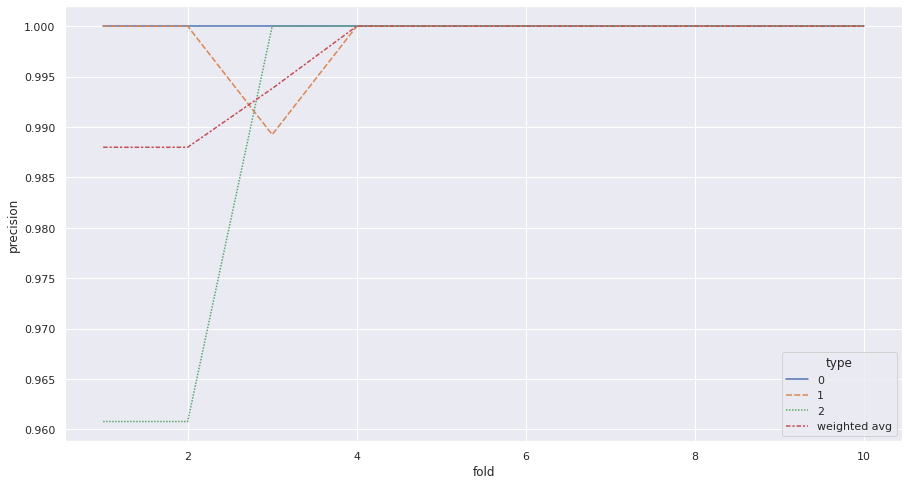

In [50]:
sns.lineplot(data=reports_df.reset_index(drop=True),x='fold',y='precision',hue='type',style='type')
plt.show()

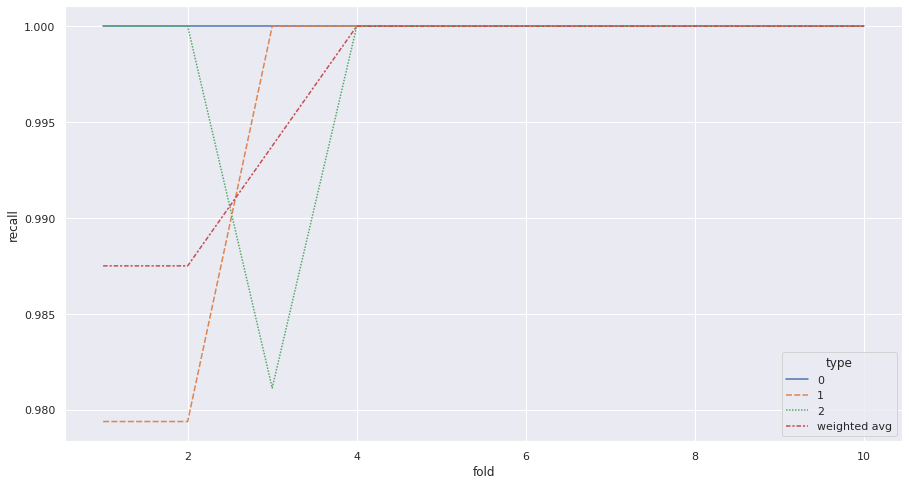

In [51]:
sns.lineplot(data=reports_df.reset_index(drop=True),x='fold',y='recall',hue='type',style='type')
plt.show()

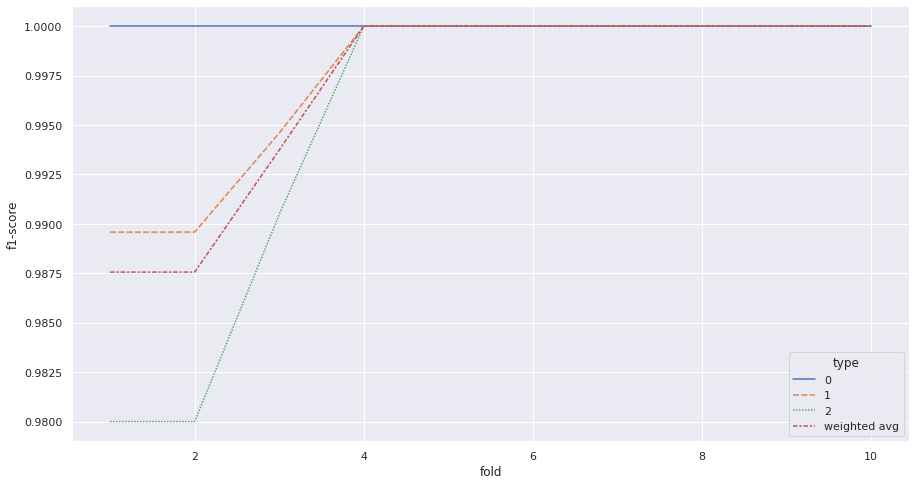

In [52]:
sns.lineplot(data=reports_df.reset_index(drop=True),x='fold',y='f1-score',hue='type',style='type')
plt.show()

In [62]:
# load best bert model
model = BertClassifier()
checkpoint = torch.load('./model/bert_best_model.pth')
model.load_state_dict(checkpoint['model'])
#evaluate
test_pred, test_target = evaluate(model, df_test.reset_index(drop=True))

Some weights of the model checkpoint at uer/roberta-base-finetuned-dianping-chinese were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Test Accuracy:  1.000


### Classification report

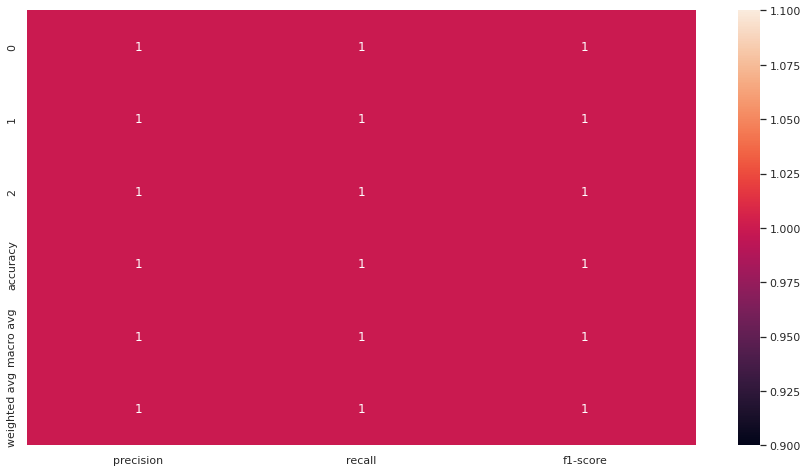

In [63]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

gin_clf_report = classification_report(test_target, test_pred, output_dict=True)
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(pd.DataFrame(gin_clf_report).iloc[:-1, :].T, annot=True)
plt.show()

### EDA

In [16]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt

def generate_word_cloud(result):
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        font_path = './font/HYShangWeiShouShuW.ttf',
        background_color = 'black'
    ).generate_from_frequencies(result)
    fig = plt.figure(
        figsize = (40, 30),
        facecolor = 'k',
        edgecolor = 'k'
    )
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

In [ ]:
import jieba.analyse

texts = [
    jieba.analyse.textrank(str(row["title"]) + " " + str(row["content"]), topK=50, withWeight=True)
    for _, row in sample_df[sample_df['category']=='N'].iterrows()
]
result = {}

for text in texts:
    for list in text:
        result[list[0]] = (list[1] + result[list[0]]) if list[0] in result else list[1]

generate_word_cloud(result)